# **`word2vec` Training Workflow (Davies Corpora)**
In this workflow, we first train `word2vec` models across years using a range of hyperparameters (e.g., vector dimensions and training epochs). The purpose is twofold: (1) to determine whether models from earlier years are reasonably stable, and (2) choose a set of hyperparameters that yield good results across all years. Models are evaluated using "intrinsic" tests of similarity and analogy performance, which we visualize using plots and analyze using linear regression.

Once we've chosen our hyperparameters, we use them to train models for every year from 1900 through 2019.

## **Setup**
### Imports

In [3]:
%load_ext autoreload
%autoreload 2

from train.word2vec import (
    train_models,
    transfer_models
)
import shutil
from pathlib import Path
from train.word2vec.evaluate import evaluate_models
from train.word2vec.visualize import plot_evaluation_results
from train.word2vec.regression_analysis import run_regression_analysis, plot_regression_results
from train.word2vec.normalize_and_align_models import normalize_and_align_vectors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configure
Here we set basic parameters: the corpus name, database path, and any corpus-specific settings.

In [4]:
corpus_name = 'COHA'
genre_focus = None
db_path_stub = f'/scratch/edk202/NLP_corpora/{corpus_name}/'

## **Test Model Hyperparameters**
### Train Models
We test models across available years, cycling through a range of reasonable hyperparameters. For Davies corpora like COHA, we constrain our grid search as follows:
1. We stick to the Skip-Gram (`skip-gram`) approach. Skip-gram generally performs well for semantic similarity tasks.
2. We test vector dimensions (`vector_size`) from 100 to 300. Our vocabulary size supports meaningful feature extraction in this range.
3. We test training epochs (`epochs`) from 10 to 30. More than 30 epochs risks overfitting.
4. We set the minimum word count (`min_count`) to 1, meaning that no words will be excluded from training. Our whitelist filtering ensures that all vocabulary words appear with sufficient frequency.
5. Weighting (`weight_by`) is set to none. `word2vec` already implements frequency-based downweighting.
6. We use a context window (`window`) appropriate for the full sentence context available in Davies corpora.

In [3]:
train_models(
    corpus_path=db_path_stub,
    genre_focus=genre_focus,
    years=(1900, 2000),
    year_step=10,
    dir_suffix='test',
    weight_by=('none',),
    vector_size=(100, 200, 300),
    window=(15,),
    min_count=(1,),
    approach=('skip-gram',),
    epochs=(10, 20, 30),
    max_parallel_models=50,
    workers_per_model=2,
    mode="resume",
    unk_mode="retain",
    use_corpus_file=True,
    cache_corpus=True
);


Scanning for existing models...


Scanning existing models: 100%|██████████| 99/99 [00:02<00:00, 40.90 files/s]

  Valid models found:    99
  Invalid/partial:       0
WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-12-24 00:43:26

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             /scratch/edk202/NLP_corpora/COHA/COHA_filtered
Model directory:      /scratch/edk202/NLP_models/COHA/COHA/models_test
Log directory:        /scratch/edk202/NLP_models/COHA/COHA/logs_test/training
Parallel models:      50

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                1900–2000 (step=10, 11 years)
Weighting:            ('none',)
Vector size:          (100, 200, 300)
Context window:       (15,)
Minimum word count:   (1,)
Approach:             ('skip-gram',)
Training epochs:      (10, 20, 30)

Data Options
────────────────────────────────────────────

Execution
────────────────────────────────────────────────────────────────────────────────────────────────────
Total models in grid: 99
Existing valid:       99
Models to train:      0
Parameter combos:     9
Years:                11



Training Models: 0 models [00:00, ? models/s]


Training Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models trained:       0
Model directory:      /scratch/edk202/NLP_models/COHA/COHA/models_test
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



### Evaluate Models

We can evaluate the models we've trained using two "intrinsic" tests: (1) a _similarity test_ assessing how well each model predicts human-rated synonymy judgments, and (2) an _analogy test_ assessing how well each model can answer SAT-style analogy questions. Test results are saved to a CSV file.

Similarity performance is the metric of choice for models intended to track semantic relatedness over time. However, we run both tests here to demonstrate the evaluation code and show that different hyperparameters lend themselves to different performance metrics.

In [5]:
evaluate_models(
    corpus_path=db_path_stub,
    genre_focus=genre_focus,
    dir_suffix='test',
    save_mode='overwrite',
    run_similarity=True,
    run_analogy=False,
    workers=100
);


WORD2VEC MODEL EVALUATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-12-26 14:27:51

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Model directory:      /scratch/edk202/NLP_models/COHA/COHA/models_test
Evaluation file:      /scratch/edk202/NLP_models/COHA/COHA/evaluation_results_test.csv
Log directory:        /scratch/edk202/NLP_models/COHA/COHA/logs_test/evaluation
Save mode:            overwrite

Evaluation Datasets
────────────────────────────────────────────────────────────────────────────────────────────────────
Similarity dataset:   ...miniforge/lib/python3.11/site-packages/gensim/test/test_data/wordsim353.tsv
Analogy dataset:      ...orge/lib/python3.11/site-packages/gensim/test/test_data/questions-words.txt

Found 99 models to evaluate



Evaluating models: 100%|██████████| 99/99 [00:00<00:00, 329.98 models/s]



Evaluation Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models evaluated:     99
Results saved to:     /scratch/edk202/NLP_models/COHA/COHA/evaluation_results_test.csv
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



### Visualize Model Performance
The code below plots the results of the similarity and analogy tests for easy inspection.
#### Similarity Results

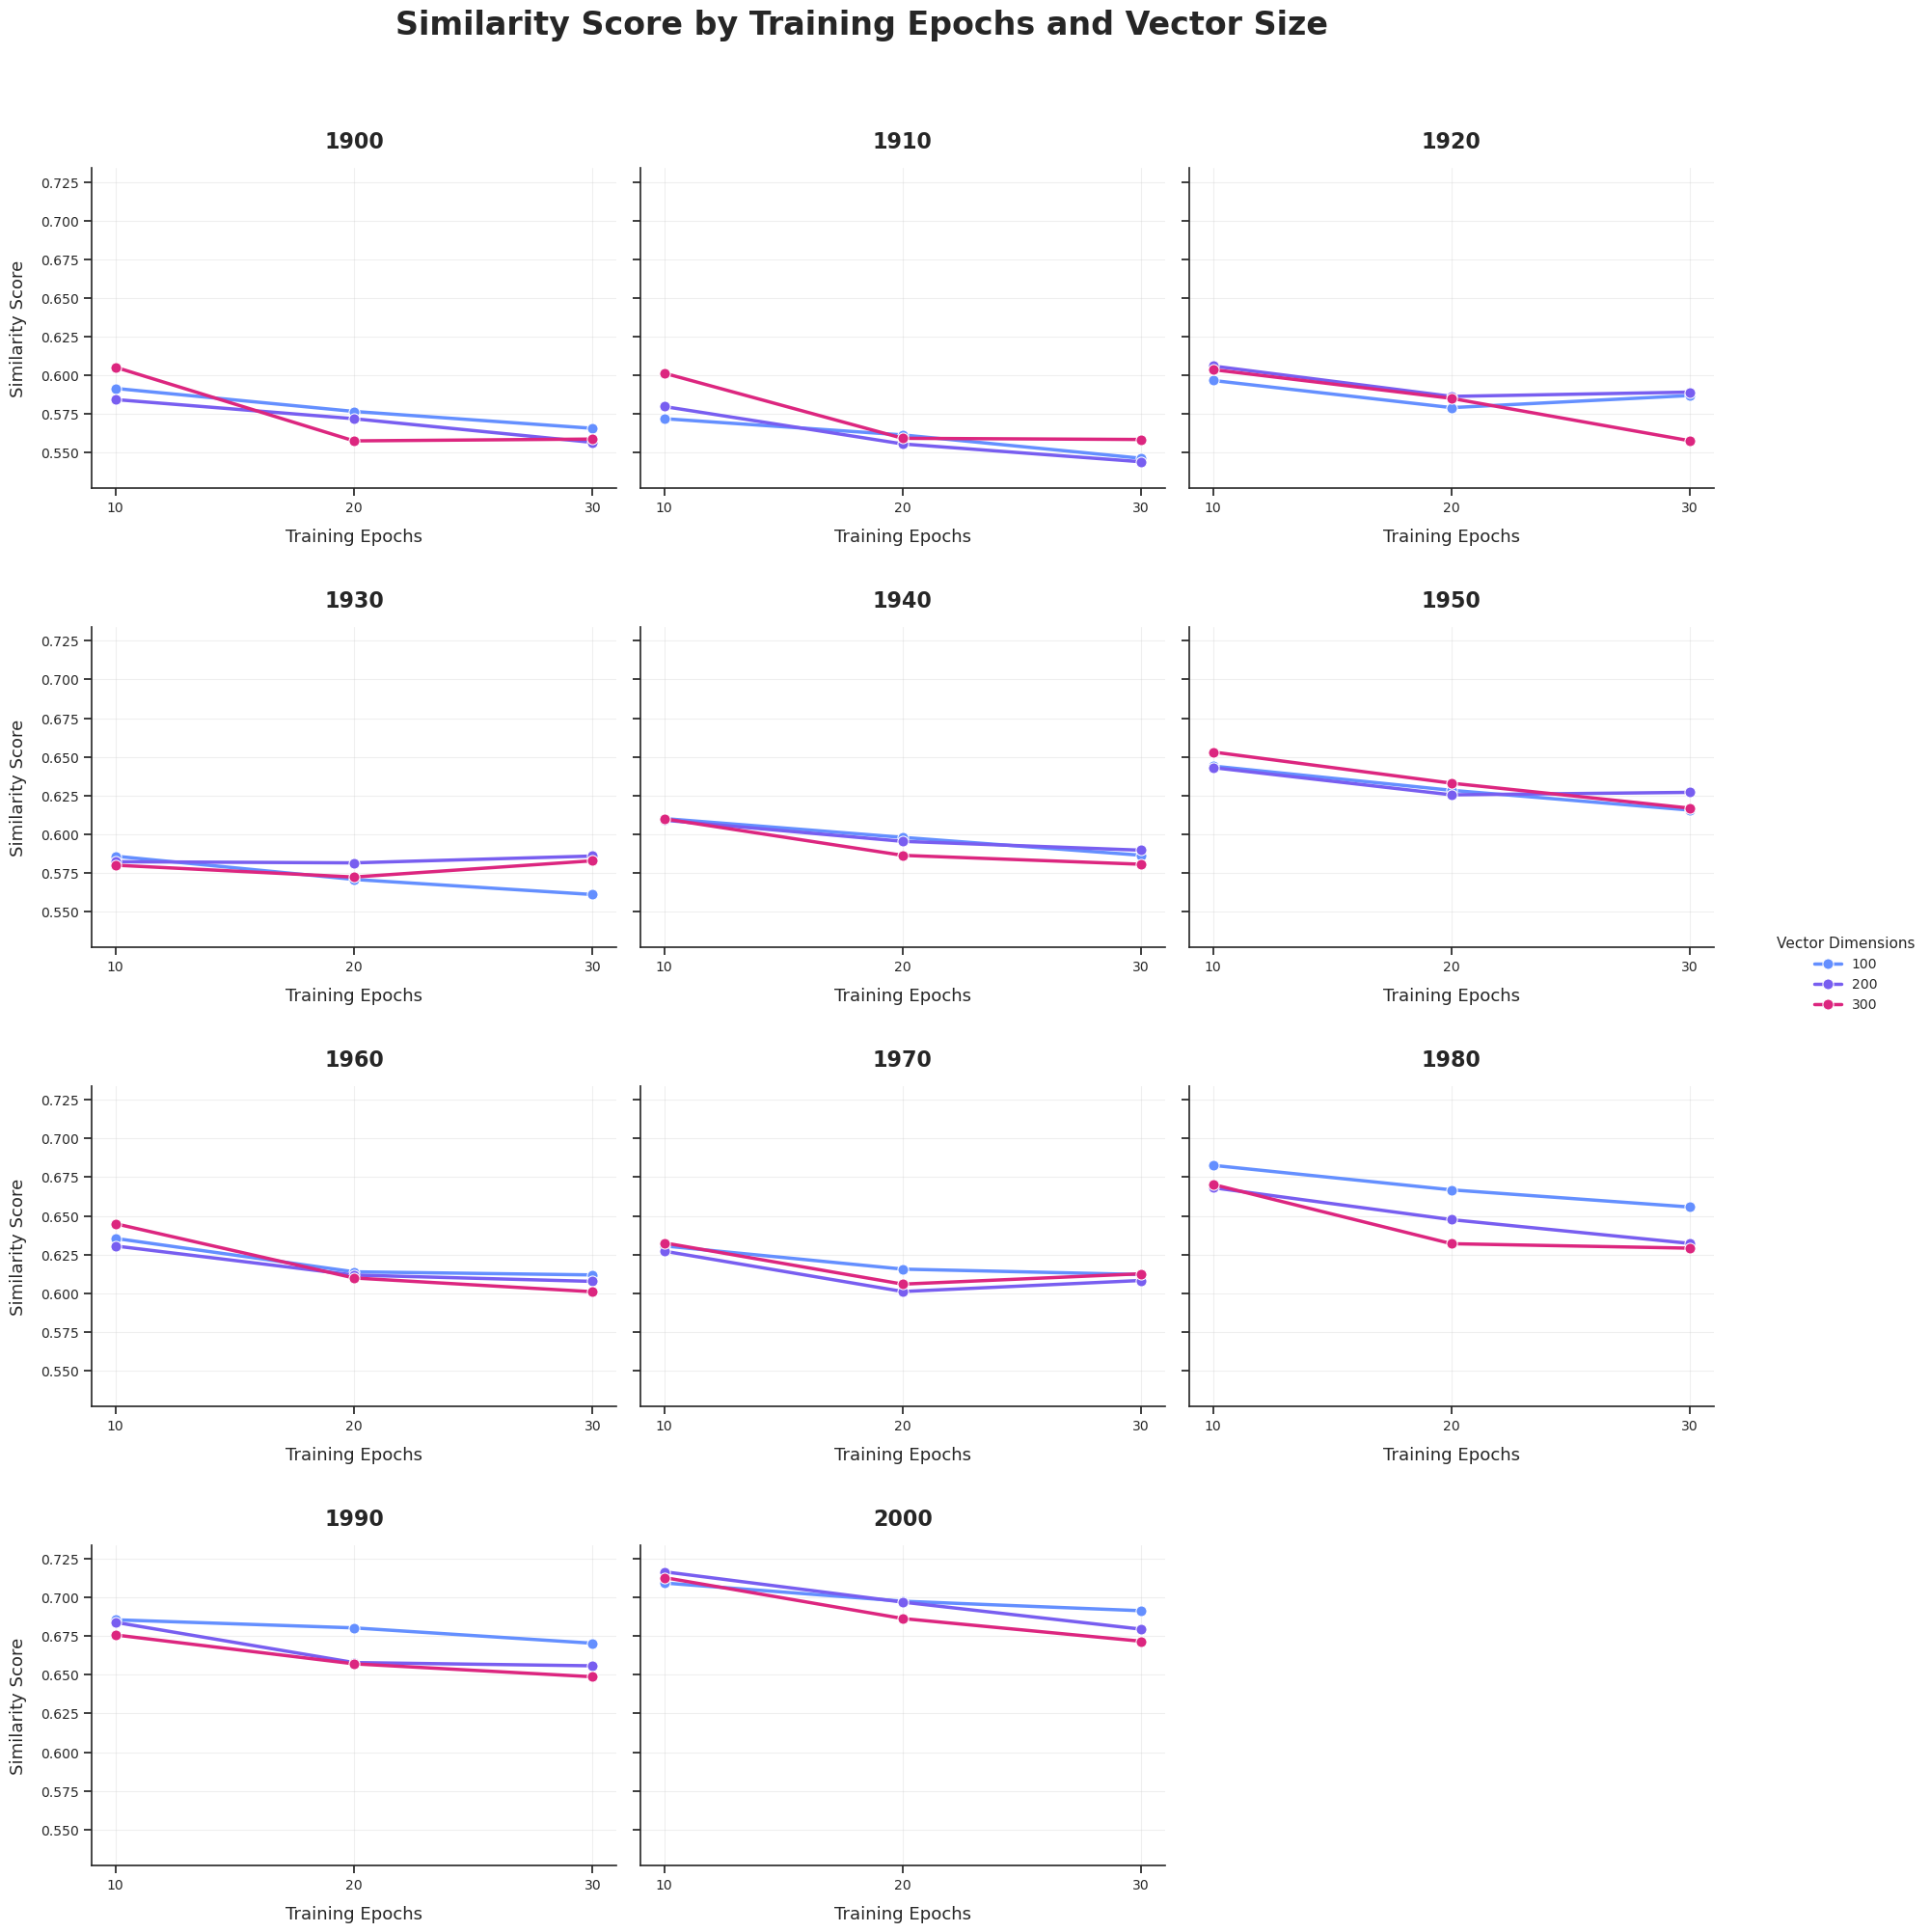

In [9]:
plot_evaluation_results(
    corpus_path=db_path_stub,
    genre_focus=genre_focus,
    dir_suffix='test',
    verbose=False,
    metric='similarity_score',
    x_vars=['epochs', 'vector_size'],
    panel_by='year',
    plot_type='line',
    plot_title='Similarity Score by Training Epochs and Vector Size'
)

#### Analogy Results

In [ ]:
plot_evaluation_results(
    corpus_path=db_path_stub,
    genre_focus=genre_focus,
    dir_suffix='test',
    verbose=False,
    metric='analogy_score',
    x_vars=['epochs', 'vector_size'],
    panel_by='year',
    plot_type='line',
    plot_title='Analogy Score by Training Epochs and Vector Size'
)

### Regression Analysis
The code below runs regression analyses on the similarity and analogy results.
#### Predictors of Similarity Performance

Loading data from: /scratch/edk202/NLP_models/COHA/COHA/evaluation_results_test.csv
Loaded 99 observations
Number of years: 11

Model specification:
  Formula: similarity_score ~ scale(year) + scale(vector_size) + scale(epochs) + scale(year):scale(vector_size) + scale(year):scale(epochs) + scale(vector_size):scale(epochs)
  Random effects: year

Fitting mixed-effects model...
Model converged successfully!

                   Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     similarity_score
No. Observations:       99          Method:                 REML            
No. Groups:             11          Scale:                  0.0001          
Min. group size:        9           Log-Likelihood:         278.2584        
Max. group size:        9           Converged:              Yes             
Mean group size:        9.0                                                 
-----------------------------------------------------------------------

/opt/miniforge/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


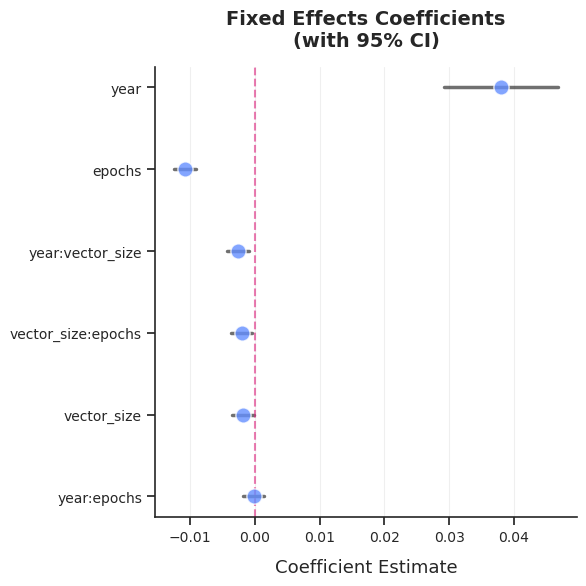

In [10]:
results = run_regression_analysis(
    corpus_path=db_path_stub,
    genre_focus=genre_focus,
    dir_suffix='test',
    model_type="auto",
    outcome='similarity_score',
    predictors=['year', 'vector_size', 'epochs'],
    interactions=[('year', 'vector_size'), ('year', 'epochs'), ('vector_size', 'epochs')],
)

plot_regression_results(results)

#### Predictors of Analogy Performance

In [ ]:
results = run_regression_analysis(
    corpus_path=db_path_stub,
    genre_focus=genre_focus,
    dir_suffix='test',
    model_type="auto",
    outcome='analogy_score',
    predictors=['year', 'vector_size', 'epochs'],
    interactions=[('year', 'vector_size'), ('year', 'epochs'), ('vector_size', 'epochs')],
)

plot_regression_results(results)

## **Transfer or Train Final Models**

We have two options now that the hyperparameter search is complete. If the desired final models are in the search set, we can simply transfer them to a new directory for analysis. Or, if the desired models aren't in the test set, we can train the final models and place them in the analysis directory.

### Transfer Final Models

In [11]:
from train.word2vec.config import construct_model_path
import os

model_dir = construct_model_path(db_path_stub)

# Add subdirectory for consistency (always done now)
corpus_name = os.path.basename(db_path_stub.rstrip('/'))
if genre_focus is not None:
    genre_suffix = "+".join(sorted(genre_focus))
    genre_subdir = f"{corpus_name}_{genre_suffix}"
else:
    genre_subdir = corpus_name
model_dir = os.path.join(model_dir, genre_subdir)

source_dir = Path(f'{model_dir}/models_test')
dest_dir = Path(f'{model_dir}/models_final')

if dest_dir.exists():
    shutil.rmtree(dest_dir)
dest_dir.mkdir(parents=True)

transferred = 0
for model_file in source_dir.glob('*.kv'):
    if 'vs100' in model_file.name and 'e010' in model_file.name:
        shutil.copy2(model_file, dest_dir / model_file.name)
        transferred += 1

print(f"Transferred {transferred} models from {source_dir} to {dest_dir}")


Transferred 11 models from /scratch/edk202/NLP_models/COHA/COHA/models_test to /scratch/edk202/NLP_models/COHA/COHA/models_final


### Train Final Models

In [3]:
train_models(
    corpus_path=db_path_stub,
    genre_focus=genre_focus,
    years=(1900, 2000),
    year_step=1,
    dir_suffix='final',
    weight_by=('none',),
    vector_size=(100,),
    window=(10,),
    min_count=(1,),
    approach=('skip-gram',),
    epochs=(10,),
    max_parallel_models=11,
    workers_per_model=9,
    mode="restart",
    unk_mode="retain",
    use_corpus_file=True
);



WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-12-22 22:51:42

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             /scratch/edk202/NLP_corpora/COHA/COHA_filtered
Model directory:      /scratch/edk202/NLP_models/COHA/COHA/models_final
Log directory:        /scratch/edk202/NLP_models/COHA/COHA/logs_final/training
Parallel models:      11

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                1900–2000 (101 years)
Weighting:            ('none',)
Vector size:          (100,)
Context window:       (10,)
Minimum word count:   (1,)
Approach:             ('skip-gram',)
Training epochs:      (30,)

Data Options
────────────────────────────────────────────────────────────────────────────────────────────────────
UNK mode:         

Training Models: 100%|██████████| 101/101 [12:00<00:00,  7.13s/ models]


Training Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models trained:       101
Model directory:      /scratch/edk202/NLP_models/COHA/COHA/models_final
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



## **Normalize and Align Models**

Before we can use the models for diachronic analysis, we need to unit-normalize the vectors and align them across years using Procrustes rotation. The `normalize_and_align_vectors` function does this.

In [3]:
normalize_and_align_vectors(
    corpus_path=db_path_stub,
    genre_focus=genre_focus,
    weighted_alignment=True,
    stability_method='combined',
    include_frequency=True,
    frequency_weight=0.3,
    dir_suffix='final',
    anchor_year=1900,
    workers=100
)


WORD2VEC MODEL NORMALIZATION & ALIGNMENT
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-12-24 01:25:17

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Model directory:      /scratch/edk202/NLP_models/COHA/COHA/models_final
Output directory:     /scratch/edk202/NLP_models/COHA/COHA/models_final/norm_and_align
Anchor year:          1900
Total models:         11
Parallel workers:     100

Alignment Method
────────────────────────────────────────────────────────────────────────────────────────────────────
Type:                 Weighted Procrustes
Stability metric:     combined
Include frequency:    Yes
Frequency weight:     0.30 (30% frequency, 70% stability)


Stability Weight Computation
════════════════════════════════════════════════════════════════════════════════════════════════════
Loading 11 models...


Loading models: 100%|██████████| 11/11 [00:00<00:00, 51.25it/s]


Computing shared vocabulary...
Excluded 1 special token(s) from shared vocabulary
Shared vocabulary size: 23980 words
Computing stability weights using combined + frequency (weight=0.30) for 23980 words across 11 models...
Computing combined stability metric...
Computing mean frequency scores...
Final weight range: 0.0259 (lowest) to 0.9719 (highest)

Top 10 highest-weighted words:
  now                  0.9719
  one                  0.9719
  make                 0.9341
  part                 0.9288
  begin                0.9142
  new                  0.9091
  city                 0.9073
  little               0.9036
  time                 0.9024
  many                 0.8959

Processing Models
════════════════════════════════════════════════════════════════════════════════════════════════════


Aligning models: 100%|██████████| 10/10 [00:32<00:00,  3.22s/ models]


Alignment Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models processed:     11
Output directory:     /scratch/edk202/NLP_models/COHA/COHA/models_final/norm_and_align
Total runtime:        0:00:35.403413
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

